# Machine Learning for Post-Processing NWM Data 
**Authors: Savalan Naser Neisary (PhD Student, CIROH & The University of Alabama)**




### 1. Introduction 
#### 1.1. Overview of the Workshop’s Goals and Structure.

This is going to be 60 minutes workshop in which we will:
- Understand the basics of machine learning and decision-tree algorithms.
- Learn how to apply and train an XGBoost model for hydrological modeling.
- Learn how to implement feature selection using the XGBoost algorithm.


We will first review the theoretical background behind decision trees and the pros and cons of the most powerful decision-tree algorithms. Then, we will start the hands-on part of the workshop on setting up our environments and getting codes and data from GitHub repositories. Next, we plan to get the data preprocessed and start model development using the XGBoost algorithm. After that, we will discuss the feature selection and hyperparameter tuning (i.e., manually and automatically). Finally, we will evaluate the performance of XGBoost in different stations. 
#### 1.2. Post-processing Hydrological Predictions

Effective and sustainable management of water resources is crucial to provide adequate water supply for human societies, regardless of their geographical location. Having an accurate and precise prediction of future hydrological variables, including streamflow is a critical component for an effective water systems management, and various studies presented different methods, such as post-processing to increase the accuracy of the hydrological predictions. Post-processing methods seek to quantify the uncertainties of hydrological model outcomes and correct their biases by using a statistical model to transform model outputs based the relationship(s) between observations and model. According to the literature Machine Learning (ML) models proved to be useful in post-processing the results of other ML or physical-based hydrological models. Therefore, in this workshop we will use decision-tree algorithms, an ensemble  subgroup of ML models, to post-process streamflow outputs of a physical-baed model. 
#### 1.3. Post-processing Retrospective National Water Model (NWM) Streamflow Data

NOAA introduced the NWM to address the need for an operational large-scale hydrological forecasting model to provide streamflow predictions in CONUS. While it has the capability of predicting streamflow in 2.7 billion water reaches, according to the literature, NWM has a low accuracy in regions west of the 95th meridian with drought and low-flow problem and in controlled basins with extensive water infrastructure. This low performance in western US watersheds is due to the lack of water operation consideration and a comprehensive groundwater and snow model beside calibrating NWM mostly with watersheds in eastern US. To compensate for NWM shortcomings in this workshop we will demonstrate how we can use decision-trees to increase its accuracy by post-processing the NWM outputs and adding the human activity impact to it.   

###### Recommended Resources:
- Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow.
- C4.5: Programs for Machine Learning.






### 2. Theoretical Background 

#### 2.1. Decision-Trees Algorithm

A decision tree is a non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks. It has a hierarchical, tree structure, which consists of a root node, branches, internal nodes and leaf nodes.Decision trees are recursively constructed multidimensional histograms. Decision tree learning employs a divide and conquer strategy by conducting a greedy search to identify the optimal split points within a tree. This process of splitting is then repeated in a top-down, recursive manner until all, or the majority of records have been classified under specific class labels. Hunt’s algorithm, which was developed in the 1960s to model human learning in Psychology, forms the foundation of many popular decision tree algorithms, such as ID3, C4.5, and CART. 

PIC


Advantages

- Easy to interpret: The Boolean logic and visual representations of decision trees make them easier to understand and consume. The hierarchical nature of a decision tree also makes it easy to see which attributes are most important, which isn’t always clear with other algorithms, like neural networks.
- Little to no data preparation required: Decision trees have a number of characteristics, which make it more flexible than other classifiers. It can handle various data types—i.e. discrete or continuous values, and continuous values can be converted into categorical values through the use of thresholds. Additionally, it can also handle values with missing values, which can be problematic for other classifiers, like Naïve Bayes.  
- More flexible: Decision trees can be leveraged for both classification and regression tasks, making it more flexible than some other algorithms. It’s also insensitive to underlying relationships between attributes; this means that if two variables are highly correlated, the algorithm will only choose one of the features to split on. 

Disadvantages

- Prone to overfitting: Complex decision trees tend to overfit and do not generalize well to new data. This scenario can be avoided through the processes of pre-pruning or post-pruning. Pre-pruning halts tree growth when there is insufficient data while post-pruning removes subtrees with inadequate data after tree construction. 
- High variance estimators: Small variations within data can produce a very different decision tree. Bagging, or the averaging of estimates, can be a method of reducing variance of decision trees. However, this approach is limited as it can lead to highly correlated predictors.  
- More costly: Given that decision trees take a greedy search approach during construction, they can be more expensive to train compared to other algorithms. 

#### 2.2. Random Forest (RF) Algorithm

RF is a widely used machine learning algorithm developed by Leo Breiman and Adele Cutler. RF is based on decision-trees, but it is based on the *Wisdom of the Crowd*, which means it aggregate the results of a group of DTs. Using the results of more than one models is called *ensemble*, so we can say that RF is an ensemble algorithm since it aggregates the results of several number of DTs. Using an ensemble of decision trees can largely reduce the overfitting and prediction variance, providing more accurate results. RF is an extension of the bagging approach, which generates a random subset of both samples and features for each model training. While a DT is based on all features to make decisions, the RF algorithm only uses a subset of features, which can reduce the influence of highly correlated features in model prediction.

Advantages

- Reduced risk of overfitting: Decision trees run the risk of overfitting as they tend to tightly fit all the samples within training data. However, when there’s a robust number of decision trees in a random forest, the classifier won’t overfit the model since the averaging of uncorrelated trees lowers the overall variance and prediction error.
- Provides flexibility: Since random forest can handle both regression and classification tasks with a high degree of accuracy, it is a popular method among data scientists. Feature bagging also makes the random forest classifier an effective tool for estimating missing values as it maintains accuracy when a portion of the data is missing.
- Easy to determine feature importance: Random forest makes it easy to evaluate variable importance, or contribution, to the model. There are a few ways to evaluate feature importance. Gini importance and mean decrease in impurity (MDI) are usually used to measure how much the model’s accuracy decreases when a given variable is excluded. However, permutation importance, also known as mean decrease accuracy (MDA), is another importance measure. MDA identifies the average decrease in accuracy by randomly permutating the feature values in oob samples.

Disadvantages

- Time-consuming process: Since random forest algorithms can handle large data sets, they can provide more accurate predictions, but can be slow to process data as they are computing data for each individual decision tree.
- Requires more resources: Since random forests process larger data sets, they’ll require more resources to store that data.
- More complex: The prediction of a single decision tree is easier to interpret when compared to a forest of them.

#### 2.3. Extreme Gradient Boosting (XGBoost) Algorithm
XGBoost is one of the algorithms based on Boosting ensemble method, and the idea behind it is to train the predictors sequentially, each trying to correct its predecessor. XGBoost method tries to fit the new predictor to the residual errors made by the previous predictor. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models. XGBoost gained significant favor in the last few years as a result of helping individuals and teams win virtually every Kaggle structured data competition. 

Advantages

- Gradient Boosting comes with an easy to read and interpret algorithm, making most of its predictions easy to handle.
- Boosting is a resilient and robust method that prevents and cubs over-fitting quite easily
- XGBoost performs very well on medium, small, data with subgroups and structured datasets with not too many features. 
- It is a great approach to go for because the large majority of real-world problems involve classification and regression, two tasks where XGBoost is the reigning king. 

Disadvantages 

- XGBoost does not perform so well on sparse and unstructured data.
- A common thing often forgotten is that Gradient Boosting is very sensitive to outliers since every classifier is forced to fix the errors in the predecessor learners. 
- The overall method is hardly scalable. This is because the estimators base their correctness on previous predictors, hence the procedure involves a lot of struggle to streamline. 


## 3. Setting Up the Codes and Notebook

#### 3.1. Access the GitHub Codes
First we download the code files from the GitHub. In the terminal you should use the following command:

#### 3.2. Import the Python Libraries
Nest we will import the libraries that we need. 

In [2]:
!pip install hydroeval xgboost

Using cached hydroeval-0.1.0-py3-none-any.whl (22 kB)


In [5]:
# system packages
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time
from tqdm import tqdm
import os
import boto3
from botocore.client import Config
from botocore import UNSIGNED

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import math
from evaluation_table import EvalTable

# model packages
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
import joblib
from shapely.geometry import Point
import geopandas as gpd
import pyproj

# Identify the path
home = os.getcwd()
parent_path = os.path.dirname(home)
input_path = f'{parent_path}/02.input/'
output_path = f'{parent_path}/03.output/'
main_path = home

## 4. Data Preprocessing
#### 4.1. Overview of the USGS Stream Station
- The dataset that we will use provides the data for seven GSL watershed stations. 
- The dataset contains climate variables, such as precipitation and temperature, water infrastructure, storage percentage, and watershed characteristics, such as average area and elevation. 
You can see the location of the station and its watershed in the Figure below. 

#### 4.2. Load Dataset
- Using the boto3 libarary we get the input dataset from the CIROH S3 bucket.

In [6]:
# List of station IDs that are of interest.
stations = ['10126000', '10130500', '10134500', '10136500', '10137500', '10141000', '10155000', '10164500', '10171000']

# Read a CSV file into a DataFrame and set the first column as the index.
df = df = pd.read_parquet(f'{input_path}final_input.parquet')

# Convert the station_id column to string data type.
df.station_id = df.station_id.astype(str)

# Convert the 'datetime' column to datetime objects.
df.datetime = pd.to_datetime(df.datetime)

# Filter the DataFrame to include only the rows where 'station_id' is in the 'stations' list.
df_modified = df[df['station_id'].isin(stations)]

# Select specific columns to create a new DataFrame.
dataset = df_modified[['station_id', 'datetime', 'Lat', 'Long', 'Drainage_area_mi2', 'Mean_Basin_Elev_ft',
       'Perc_Forest', 'Perc_Develop', 'Perc_Imperv', 'Perc_Herbace',
       'Perc_Slop_30', 'Mean_Ann_Precip_in', 's1',
       's2', 'storage', 'swe', 'NWM_flow', 'DOY','tempe(F)', 'precip(mm)', 'flow_cfs']]

# Extract a list of unique station IDs from the modified dataset.
station_list = dataset.station_id.unique()


#### 4.3. Visualizing the Data
- The takeaway from data visualization is to gather information about data distribution, outliers, missing values, correlation between different variables, and time dependencies between variables.
- Here, we will use boxplots, histograms, and combo bar and line plots to show outliers, distribution, and time dependencies in streamflow, precipitation, temperature, and SWE.

First, we will plot the time dependencies using bar and line plots for streamflow vs SWE. 

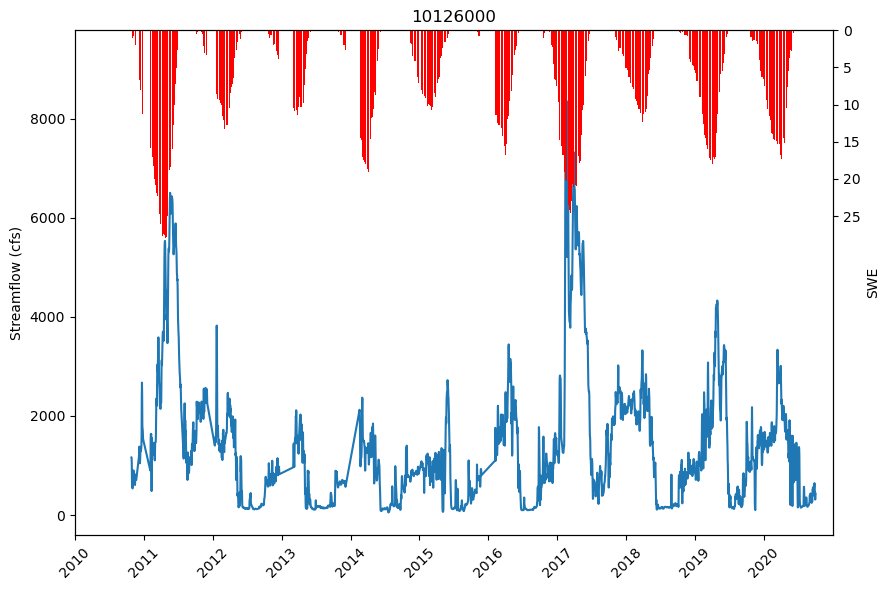

CPU times: user 7.01 s, sys: 36 ms, total: 7.04 s
Wall time: 7.04 s


In [19]:
%%time

figsize = (9, 6)  # Set the figure size for the plot.
fig, ax = plt.subplots(figsize=figsize)


# Extract data for the current station.
temp_df_1 = dataset[dataset.station_id == station_list[0]]
# Set 'datetime' as the index for the DataFrame for plotting.
temp_df_2 = temp_df_1.set_index('datetime')
# Plot 'flow_cfs' on the primary y-axis.
ax.plot(temp_df_2.index, temp_df_2['flow_cfs'])
# Set x-axis limits from the minimum to maximum year of data.
start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
ax.set_xlim(start_year, end_year)
# Get current x-tick labels and set their rotation for better visibility.
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45)

# Create a secondary y-axis for Snow Water Equivalent (SWE).
ax2 = ax.twinx()
# Plot SWE as a bar graph on the secondary y-axis.
ax2.bar(temp_df_2.index, temp_df_2['swe'], label='Inverted', color='red')
# Set the y-axis limits for SWE, flipping the axis to make bars grow downward.
ax2.set_ylim(max(temp_df_2['swe']) + 40, 0)
# Set label for the secondary y-axis.
ax2.set_ylabel('SWE')
# Define custom ticks for the secondary y-axis.
ax2.set_yticks(np.arange(0, max(temp_df_2['swe']), 5))

# Set the title of the subplot to the station ID.
ax.set_title(f'{station_list[0]}')
# Set the x-axis label for subplots in the last row.
if i // n_cols == n_rows - 1:
    ax.set_xlabel('Datetime (day)')

# Set the y-axis label for subplots in the first column.
if i % n_cols == 0:
    ax.set_ylabel('Streamflow (cfs)')
else:
    # Hide any unused axes.
    ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


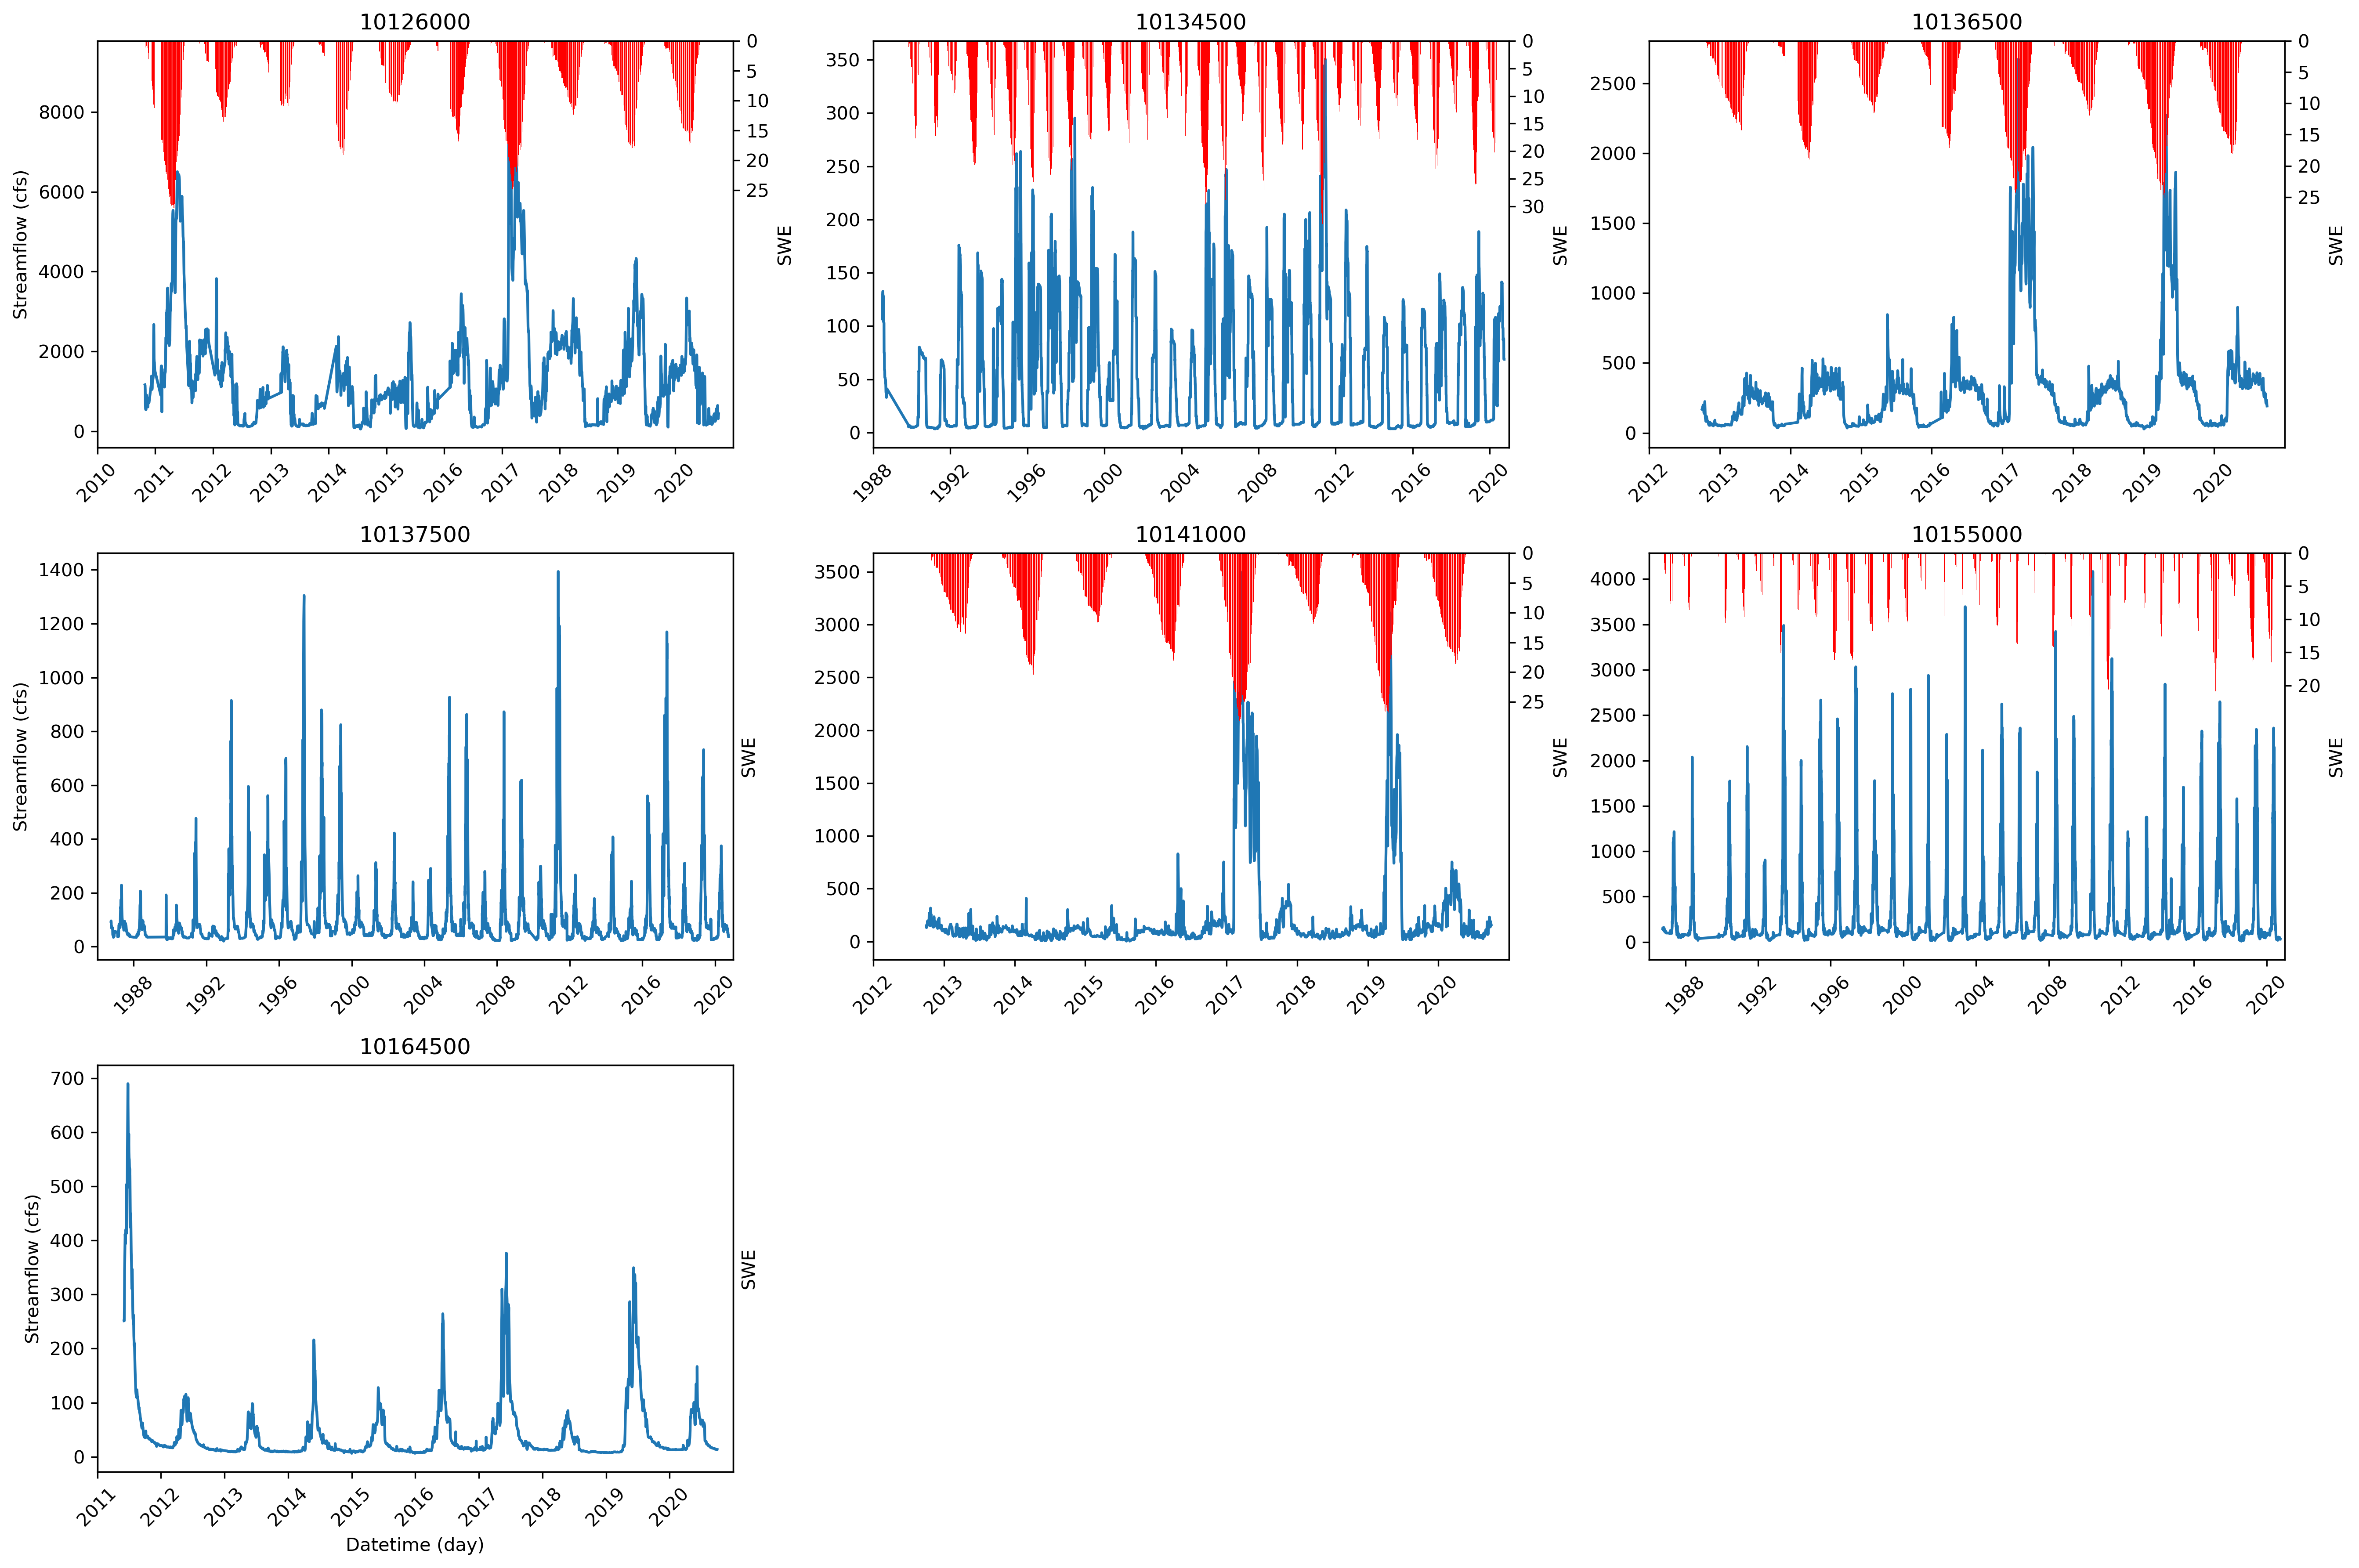

CPU times: user 45.1 s, sys: 558 ms, total: 45.6 s
Wall time: 45.6 s


In [7]:
%%time
# Initialize variables for the number of plots, columns, and rows based on the number of unique stations.
n_subplots = len(station_list)
n_cols = int(math.ceil(math.sqrt(n_subplots)))  # Calculate columns as the ceiling of the square root of number of subplots.
n_rows = int(math.ceil(n_subplots / n_cols))  # Calculate rows as the ceiling of the ratio of subplots to columns.
figsize = (18, 12)  # Set the figure size for the plot.
# Create a figure and a grid of subplots with the specified number of rows and columns.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()  # Flatten the axes array for easier iteration.

# Iterate over each axis to plot data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:  # Check if the current index is less than the number of subplots to populate.
        # Extract data for the current station.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        # Set 'datetime' as the index for the DataFrame for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot 'flow_cfs' on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cfs'])
        # Set x-axis limits from the minimum to maximum year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Get current x-tick labels and set their rotation for better visibility.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a secondary y-axis for Snow Water Equivalent (SWE).
        ax2 = ax.twinx()
        # Plot SWE as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['swe'], label='Inverted', color='red')
        # Set the y-axis limits for SWE, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['swe']) + 40, 0)
        # Set label for the secondary y-axis.
        ax2.set_ylabel('SWE')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['swe']), 5))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


The next plot shows precipitation vs streamflow. 

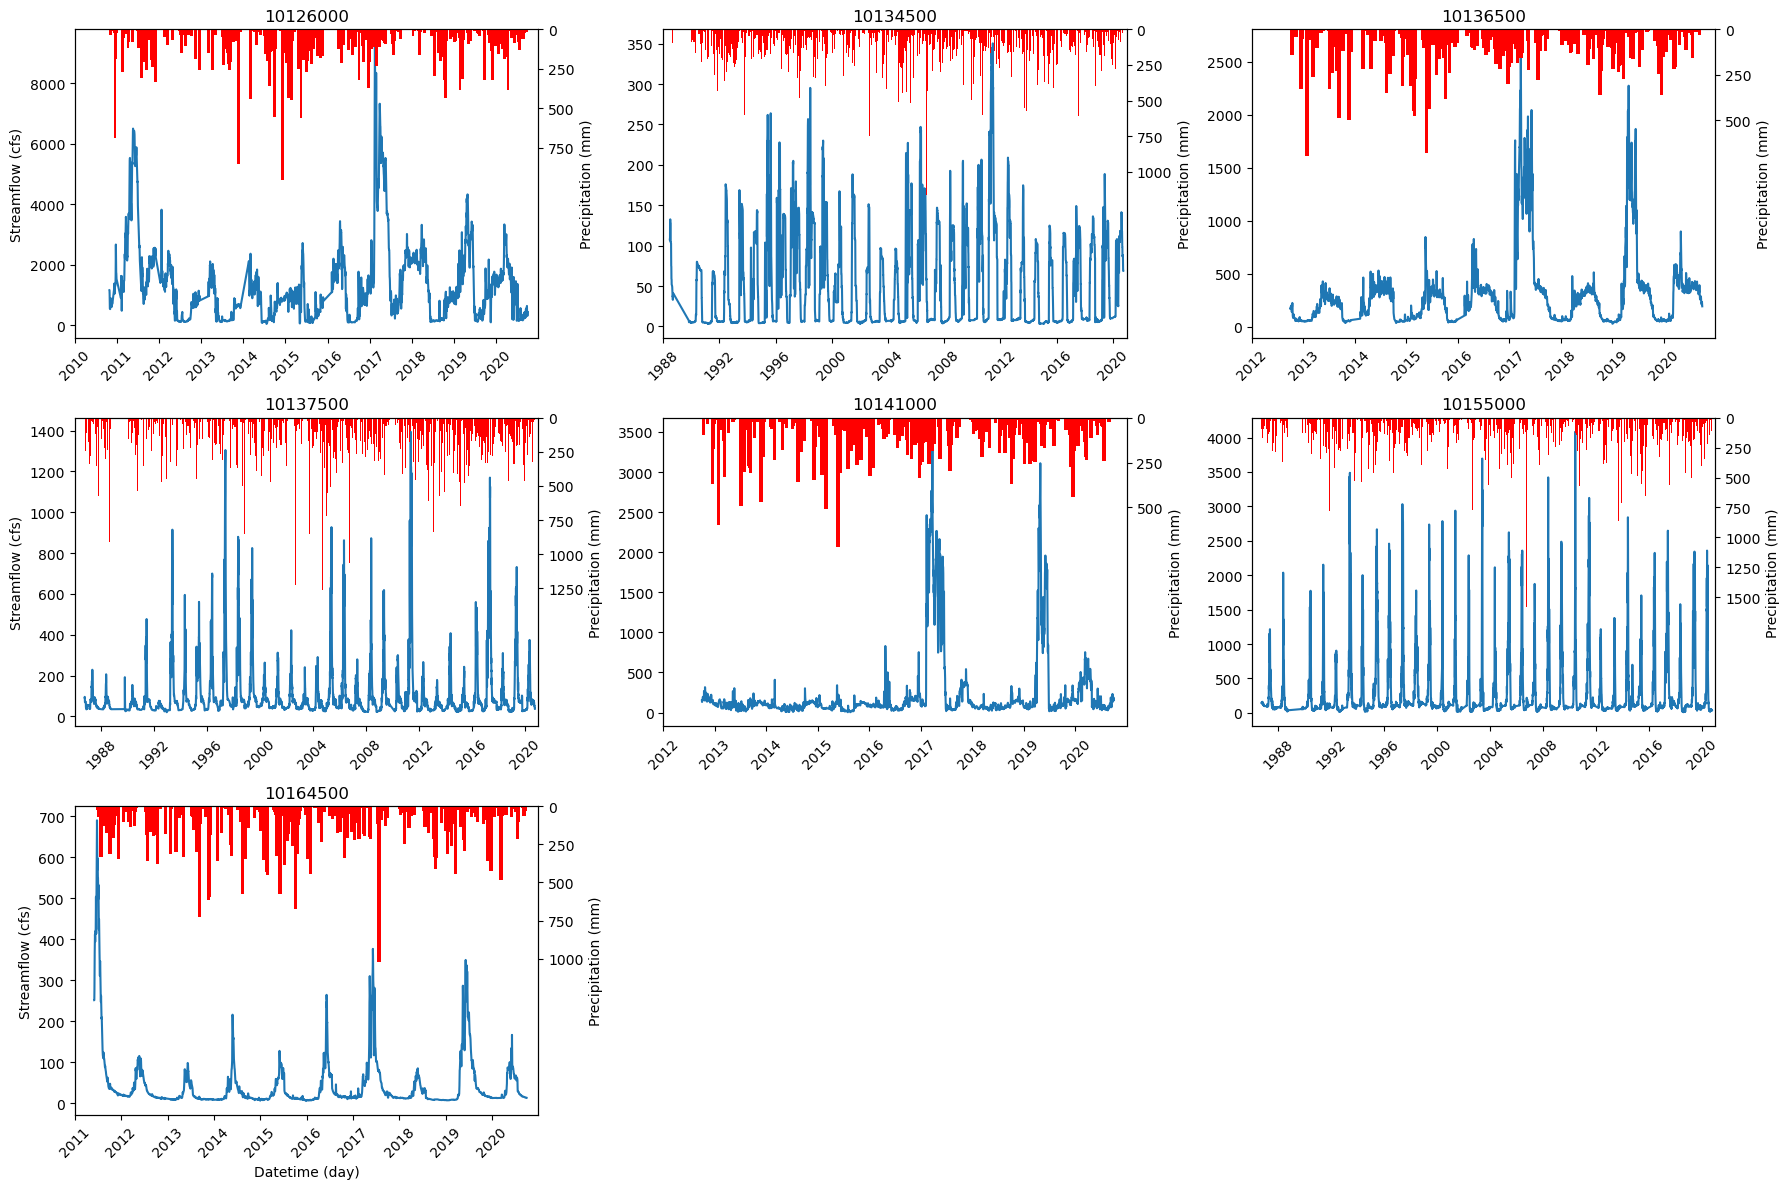

CPU times: user 45.5 s, sys: 216 ms, total: 45.7 s
Wall time: 45.7 s


In [23]:
%%time
# Calculate the number of subplots needed based on the number of unique stations.
n_subplots = len(station_list)
# Determine the number of columns in the subplot grid by taking the ceiling of the square root of 'n_subplots'.
n_cols = int(math.ceil(math.sqrt(n_subplots)))
# Determine the number of rows in the subplot grid by dividing 'n_subplots' by 'n_cols' and taking the ceiling of that.
n_rows = int(math.ceil(n_subplots / n_cols))
# Set the figure size for the subplots.
figsize = (18, 12)
# Create a grid of subplots with specified number of rows and columns and figure size.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
# Flatten the axes array for easier iteration.
axes = axes.flatten()

# Iterate over the axes to plot the data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:
        # Extract the data for the current station from the dataset.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        # Set 'datetime' as the index for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot the 'flow_cfs' data on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cfs'])
        # Set the x-axis limits from the first to the last year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Rotate x-axis labels for better readability.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a second y-axis for the precipitation data.
        ax2 = ax.twinx()
        # Plot the 'precip(mm)' data as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['precip(mm)'], label='Inverted', color='red', width=25)
        # Set the y-axis limits for precipitation, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['precip(mm)']) + 1000, 0)
        # Set the label for the secondary y-axis.
        ax2.set_ylabel('Precipitation (mm)')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['precip(mm)']), 250))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


#### 4.4. Splitting the Data 
We split 80 percent of the data for training and the rest for testing the model.

In [20]:
# Create empty DataFrames for training and testing datasets.
data_train = pd.DataFrame()
data_test = pd.DataFrame()

# Loop through each station name in the list of station IDs.
for station_name in station_list:
    # Extract data for the current station and reset the index.
    temp_df_1 = dataset[dataset.station_id == station_name].reset_index(drop=True)
    
    # Determine the maximum and minimum years in the dataset for the current station.
    end_year = temp_df_1.datetime.dt.year.max()
    start_year = temp_df_1.datetime.dt.year.min()
    
    # Calculate the duration in years between the earliest and latest data points.
    duration = end_year - start_year
    
    # Calculate the division year to split training and testing data (80% for training).
    division_year = start_year + int(duration * 0.8)
    
    # Select data from the start year up to the division year for training, reset the index, and append to the training DataFrame.
    data_train = pd.concat((data_train.reset_index(drop=True), temp_df_1[temp_df_1.datetime < f'{division_year}-01-01'].reset_index(drop=True)), axis=0).reset_index(drop=True)
    
    # Select data from the division year onward for testing, reset the index, and append to the testing DataFrame.
    data_test = pd.concat((data_test.reset_index(drop=True), temp_df_1[temp_df_1.datetime >= f'{division_year}-01-01'].reset_index(drop=True)), axis=0).reset_index(drop=True)


## 5. Model Development 
#### 5.1. Defining the XGBoost Model 
As mentioned, we will use XGBoost in our tutorial, and we will use the  [dmlc XGBoost package](https://xgboost.readthedocs.io/en/stable/). Understanding and tuning the model parameters is critical in any ML model development since it will affect the final model performance. The XGBoost model has different parameters, and here, we will work on the three most important parameters of XGBoost:
  
* **`max_depth`** This parameter determines the maximum depth of each tree. This setting controls the complexity of the tree by restricting the number of levels or splits within it. Increasing the *max_depth* can help capture more complex patterns in the data, but it can also lead to overfitting, where the model becomes too specialized in the training data and performs poorly on new data. On the other hand, reducing the *max_depth* can help prevent overfitting, but it can also result in underfitting, where the model misses relevant patterns.

* **`n_estimators`** It determines the number of trees in the ensemble and controls how many boosting rounds the algorithm should perform. Boosting rounds add new trees that attempt to correct errors from previous rounds, leading to improved performance up to a point. However, too many trees can result in overfitting, where the model performs well on training data but poorly on unseen data. It also increases the running time of the model.

* **`eta`** It controls the step size used to update the weights of the trees during training and determines how much each new tree contributes to the overall model. A smaller *eta* value can make the model more robust to overfitting by slowing the learning process. However, more boosting rounds (n_estimators) may be required to achieve good performance. Conversely, a larger *eta* value allows the model to learn faster but increases the risk of overfitting.

We will call the *XGBRegressor()* model and specify its parameters.

**To make the process faster for this part we only use one station.**

Let's start investigating different parameters and find out the best possible values!!!!!!!!!!!!!!!!!

In [21]:
def evaluate_model(params, X_train, y_train):
    # Create an XGBoost regressor model with the provided parameters.
    model = xgb.XGBRegressor(**params)
    
    # Set up cross-validation configuration with 10 splits and 3 repeats, and a fixed random state for reproducibility.
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # Perform cross-validation to evaluate the model using the negative mean absolute error as the scoring method.
    # 'n_jobs=-1' enables using all CPU cores for parallel computation.
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    # Return the scores from the cross-validation.
    return scores


In [22]:
# Define the station ID to be used.
station_name = '10126000'
# Select and reset the index of feature columns from the training data where station ID matches.
x_train = data_train[data_train.station_id == station_name].iloc[:, 2:-1].reset_index(drop=True)
# Select and reset the index of the target column from the training data where station ID matches.
y_train = data_train[data_train.station_id == station_name].iloc[:, -1].reset_index(drop=True)

# Define the initial parameters for the XGBoost model.
# n_estimators => 100, 2000
# max_depth => 3, 10
# eta => 0.01, 0.1

params = {
    'n_estimators': 200,
    'max_depth': 5,
    'eta': 0.1,
}

# Evaluate the model with initial parameters and calculate the mean of absolute scores.
current_score = abs(evaluate_model(params, x_train, y_train).mean())
print(f"Initial score (cfs): {current_score} with params: {params}")

# Initialize the interactive tuning loop.
continue_tuning = True
while continue_tuning:
    # Prompt the user if they want to continue tuning.
    print('=====================================================================================')
    change = input("Do you want to change any variable? (y/n): ")
    if change.lower() == 'y':
        # Ask which parameter to change.
        variable = input("Which variable number? (n_estimators(1)/max_depth(2)/eta(3)):")
        # Map user input to the corresponding parameter.
        if variable == '1':
            variable = 'n_estimators'
        elif variable == '2':
            variable = 'max_depth'
        elif variable == '3':
            variable = 'eta'
        else:
            print('Error: Wrong Number')
            break

        # Prompt for the new value and validate the type.
        value = input(f"Enter the new value for {variable} (previous value {params[variable]}): ")
        if variable == 'n_estimators' or variable == 'max_depth':
            value = int(value)
        else:
            value = float(value)

        # Update parameter and re-evaluate the model.
        old_param = params[variable]
        params[variable] = value
        new_score = evaluate_model(params, x_train, y_train)
        print('**********************************************')
        print('Previous Mean Score (cfs): %.3f (Previous Score SD: %.3f)' % (abs(current_score.mean()), current_score.std()))
        print('New Mean Score (cfs): %.3f (New Score SD: %.3f)' % (abs(new_score.mean()), new_score.std()))
        print('**********************************************')
        current_score = new_score

        # Prompt if the new parameter setting should be kept.
        keep_answer = input(f"Do you want to keep the new variable?(y/n): ")
        if keep_answer == 'n':
            params[variable] = old_param
    else:
        # Exit tuning loop.
        continue_tuning = False
        print(f"Finished tuning ====================> Final parameters: {params}.")


Initial score (cfs): 152.80558477080083 with params: {'n_estimators': 200, 'max_depth': 5, 'eta': 0.1}


Do you want to change any variable? (y/n):  n


Finished tuning ====================> Final parameters: {'n_estimators': 200, 'max_depth': 5, 'eta': 0.1}.


#### !!!! Don't forget to train and save your model after tuning the hyperparameters as a Pickle file.


In [24]:
# Instantiate an XGBoost regressor model with the specified parameters.
xgboost_model = xgb.XGBRegressor(**params)

# Fit the model using the training dataset.
xgboost_model.fit(x_train, y_train)

# Save the trained model to a file using the pickle library for later use.
# 'save_path' should be defined earlier in your script and point to a directory where you have write permissions.
pickle.dump(xgboost_model, open(f'{output_path}best_manuall_model.pkl', "wb"))


In [26]:
data_train.to_pickle(f"{output_path}train_dataset.pkl")
data_test.to_pickle(f"{output_path}test_dataset.pkl")

[**LETS GO TO THE NEXT PART**](./02.tutorial_post_processing_xgboost_automatic_tuning.ipynb)